# Introduction

Dataset obtained from [Kaggle](https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2/data)

# Import Libraries

In [53]:
# library dataframe
import pandas as pd
# library olah data numerical
import numpy as np
# library statistik
from scipy.stats import pearsonr, kendalltau, spearmanr
import glob
import os

# Data visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# libraries Data Preprocessing
from sklearn.model_selection import train_test_split # splittingdata
from feature_engine.outliers import Winsorizer # outlier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler # scalling
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder # encoder
from imblearn.over_sampling import SMOTE # balancing

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Library handling outlier
from feature_engine.outliers import Winsorizer

# Pemodelan ML
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report


# Evaluasi model
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, precision_score, recall_score, f1_score,accuracy_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
import os
import shutil

# Tuning
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16 

from collections import Counter

# lib pipelines
from sklearn.pipeline import Pipeline

# Save model
import pickle
import joblib
import json

# Library to suppress warnings or deprecation notes
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

# Data Loading

In [54]:
# Define the base directory path
base_dir = 'images'

seed = 69

# Create an ImageDataGenerator for loading and augmenting the images
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize the pixel values
    validation_split=0.2,     # Split 20% of data for validation
)
# Define augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,      # Rotation range in degrees
    width_shift_range=0.2,  # Width shift range as a fraction of total width
    height_shift_range=0.2, # Height shift range as a fraction of total height
    shear_range=0.2,        # Shear intensity in degrees
    zoom_range=0.2,         # Range for random zoom
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Strategy used for filling in newly created pixels
)

# Create the generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=seed
)

# Create a validation data generator
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',      # Set as validation data
    seed=seed
)

# Create a test data generator
test_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',      # Set as test data (same as validation for demonstration)
    seed=seed
)

# Ensure generators are created successfully
if train_generator is None:
    raise ValueError("Training generator creation failed.")
if validation_generator is None:
    raise ValueError("Validation generator creation failed.")

Found 23642 images belonging to 10 classes.
Found 4725 images belonging to 10 classes.
Found 4725 images belonging to 10 classes.


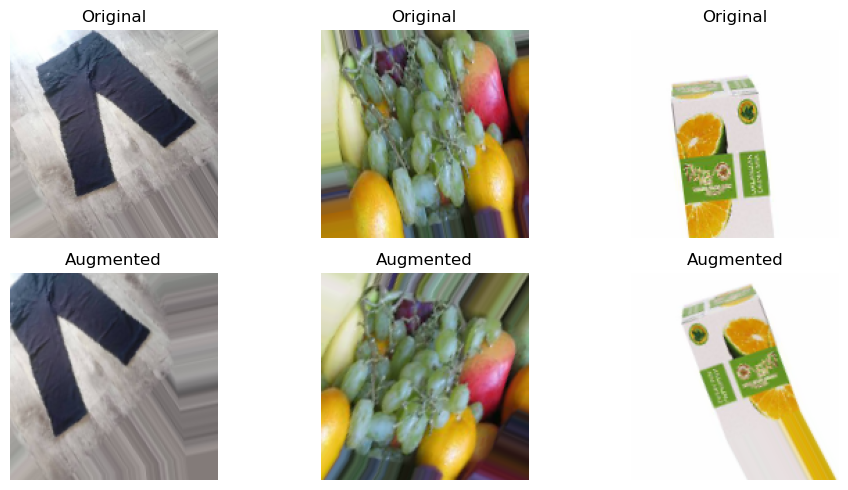

In [55]:
import matplotlib.pyplot as plt

# Get a batch of images from the generator (non-augmented)
x_batch, y_batch = train_generator[0]

# Get a batch of augmented images
augmented_images = [train_datagen.random_transform(image) for image in x_batch]

# Number of images to plot
num_images = min(len(x_batch), 3)  # Plot up to 3 images

# Plot the non-augmented and augmented images
plt.figure(figsize=(10, 5))
for i in range(num_images):
    # Plot non-augmented image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(x_batch[i])
    plt.title('Original')
    plt.axis('off')
    
    # Plot augmented image
    plt.subplot(2, num_images, i + num_images + 1)
    plt.imshow(augmented_images[i])
    plt.title('Augmented')
    plt.axis('off')

plt.tight_layout()
plt.show()


This shows images before and after augemntation

# EDA

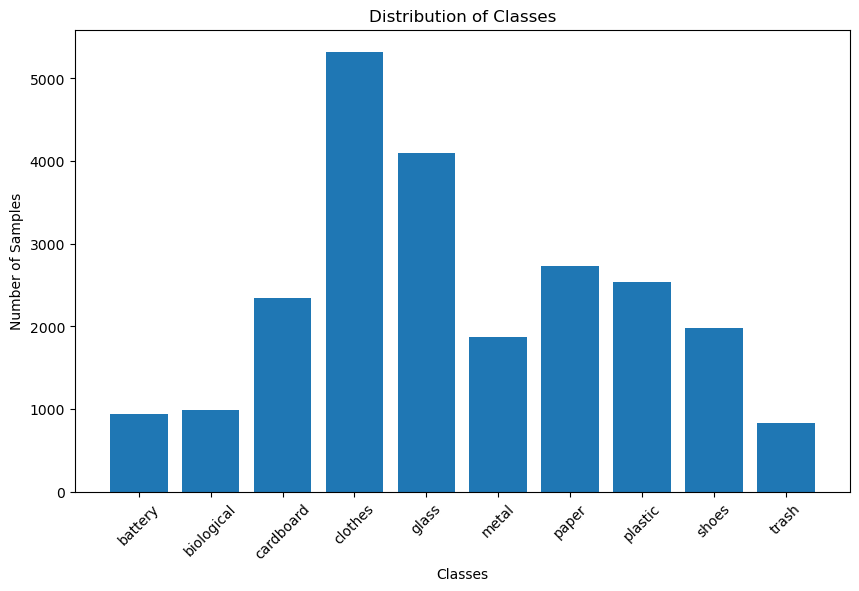

In [56]:

# Get the class indices
class_indices = train_generator.class_indices

# Invert the dictionary to get class labels as keys
class_labels = {v: k for k, v in class_indices.items()}

# Count the number of samples for each class in the training set
class_counts = {class_labels[idx]: np.sum(train_generator.classes == idx) for idx in range(len(class_labels))}

# Plot the distribution of classes
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes')
plt.xticks(rotation=45)
plt.show()


In [57]:
def plot_images(images_arr, titles=None):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    for i, ax in enumerate(axes):
        ax.imshow(images_arr[i])
        ax.axis('off')
        if titles and len(titles) > i:  # Check if titles exist and index i is within bounds
            ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()


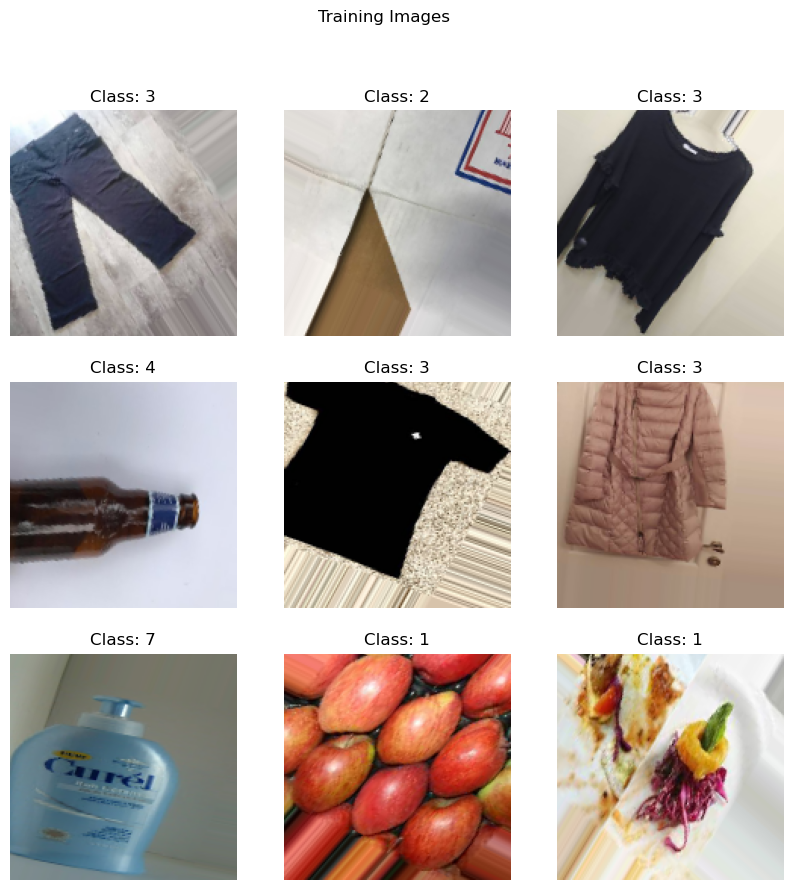

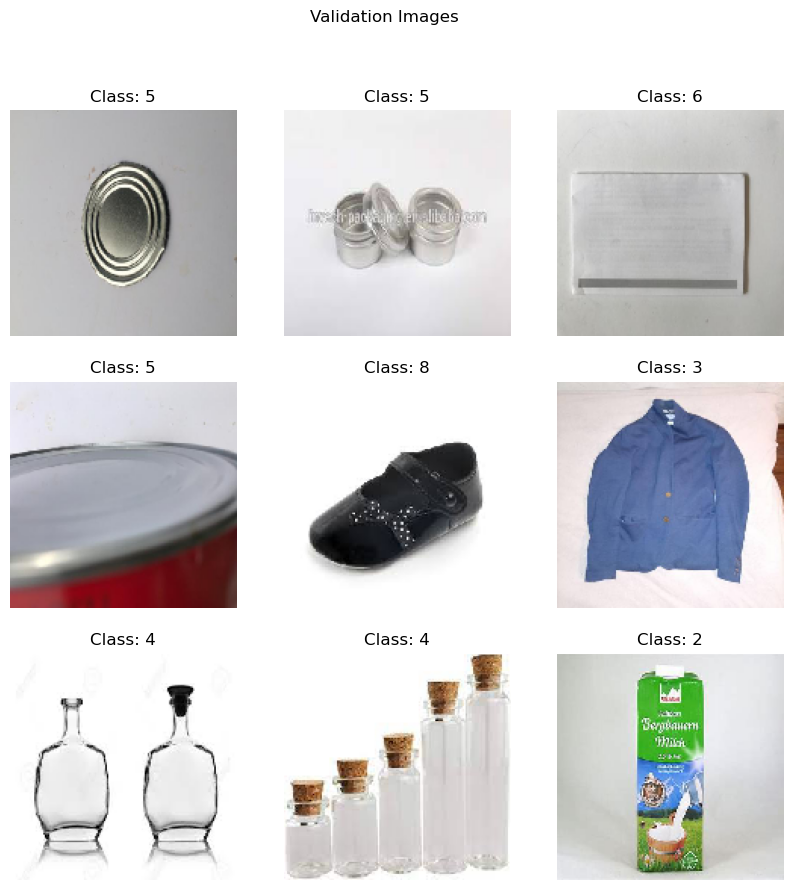

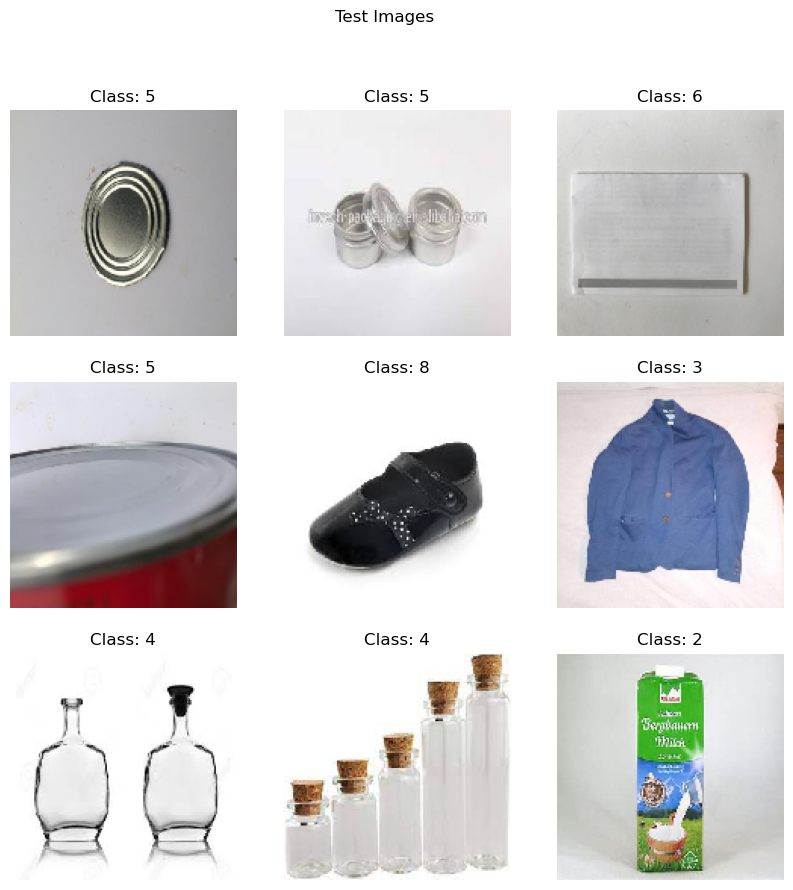

In [58]:
import matplotlib.pyplot as plt

# Display images from the training set
plt.figure(figsize=(10, 10))
for i in range(9):
    x_train, y_train = train_generator[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[0])
    plt.title(f'Class: {y_train[0].argmax()}')
    plt.axis('off')
plt.suptitle('Training Images')
plt.show()

# Display images from the validation set
plt.figure(figsize=(10, 10))
for i in range(9):
    x_val, y_val = validation_generator[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_val[0])
    plt.title(f'Class: {y_val[0].argmax()}')
    plt.axis('off')
plt.suptitle('Validation Images')
plt.show()

# Display images from the test set
plt.figure(figsize=(10, 10))
for i in range(9):
    x_test, y_test = test_generator[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[0])
    plt.title(f'Class: {y_test[0].argmax()}')
    plt.axis('off')
plt.suptitle('Test Images')
plt.show()


We can see that all sets were successfully generated. Only the training set has been augmented

# Preprocessing

## Image Augmentation


Image augmentation is a technique used in computer vision and deep learning to artificially expand the size of a training dataset by creating modified versions of images in the dataset. This helps improve the performance and generalization ability of models, particularly in tasks such as image classification, object detection, and segmentation.

Training set has already been augmented during the loading step.

# Feature Engineering


In [59]:
from PIL import Image
import tensorflow as tf

def remove_unreadable_images(generator):
    readable_files = []
    for i in range(len(generator.filenames)):
        file_path = generator.filepaths[i]
        try:
            # Check file extension to ensure it's a supported image format
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                with tf.io.gfile.GFile(file_path, 'rb') as f:
                    img = Image.open(f)
                    img.verify()
                    readable_files.append(file_path)
            else:
                print(f"Skipping '{file_path}' because it's not in a supported image format.")
        except Exception as e:
            print(f"Image '{file_path}' is not readable. Error: {e}")

    return readable_files

# Remove unreadable images from training set
readable_train_files = remove_unreadable_images(train_generator)
train_generator.filenames = readable_train_files

# Remove unreadable images from validation set
readable_validation_files = remove_unreadable_images(validation_generator)
validation_generator.filenames = readable_validation_files

# Remove unreadable images from test set
readable_test_files = remove_unreadable_images(test_generator)
test_generator.filenames = readable_test_files

# Print the number of remaining images after removing unreadable ones
print(f"Number of remaining images in training set: {len(readable_train_files)}")
print(f"Number of remaining images in validation set: {len(readable_validation_files)}")
print(f"Number of remaining images in test set: {len(readable_test_files)}")


Number of remaining images in training set: 23642
Number of remaining images in validation set: 4725
Number of remaining images in test set: 4725


# Model Definition

## Sequential

Sequential API in Keras
The Sequential API is one of the ways to create and configure models in Keras, a popular high-level neural networks API written in Python and capable of running on top of TensorFlow. It is designed for simple, straightforward models where each layer has exactly one input tensor and one output tensor. The Sequential API allows you to build models layer-by-layer in a step-by-step fashion.

Key Features of the Sequential API
* Simplicity: The Sequential API is straightforward and easy to use, making it ideal for beginners and simple network architectures.
* Layer Stacking: Layers are stacked on top of each other sequentially, with each layer’s output serving as the next layer’s input.
* Less Flexible: Compared to the Functional API, it is less flexible and suitable mainly for models where layers are stacked in a single linear pipeline without complex architectures like multi-input or multi-output models.

In [60]:

# Define the model
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add dense (fully connected) layers
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax')) 

In [61]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,038,794 (72.63 MB)

 Trainable params: 19,038,794 (72.63 MB)

 Non-trainable params: 0 (0.00 B)

Summary
* Total Parameters: 19,038,794
* Trainable Parameters: 19,038,794
* Non-trainable Parameters: 0
* This CNN architecture is designed for image classification tasks, likely involving 10 classes given the 10 neurons in the final dense layer. The network progressively reduces the spatial dimensions of the input image while increasing the depth through convolutional layers, and then flattens the output before passing it through dense layers to produce the final classification output.

In [62]:
# Define a ModelCheckpoint callback
checkpoint_path = "model_checkpoint.keras"  # Ensure this ends with .keras
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

In [63]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Funtional API

The Functional API is a way to create models in Keras, a high-level neural networks API running on top of TensorFlow. It is designed to handle more complex model architectures than the Sequential API, allowing for models with multiple inputs, multiple outputs, shared layers, and non-linear topology.

Key Features
* Flexibility: The Functional API allows you to create complex models that are not possible with the Sequential API. This includes models with multiple inputs, multiple outputs, and layers that are connected in non-linear ways.
* Graph-based: The model is defined as a directed acyclic graph (DAG) of layers. This graph-based approach enables the creation of complex architectures such as residual networks, inception modules, and more.
* Reusability: Layers and models can be reused multiple times, and you can create models that share layers.

In [64]:
# Define the model using the Functional API
input_layer = Input(shape=(150, 150, 3))

In [65]:
# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

In [66]:
# Fully connected layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

In [67]:
train_generator

In [68]:
# Create the model
modelF = Model(inputs=input_layer, outputs=output_layer)

In [69]:
# Compile the model
modelF.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
modelF.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,038,794 (72.63 MB)

 Trainable params: 19,038,794 (72.63 MB)

 Non-trainable params: 0 (0.00 B)

Summary
* Total Parameters: 19,038,794
* Trainable Parameters: 19,038,794
* Non-trainable Parameters: 0
* This CNN is designed to process images, progressively reducing their spatial dimensions while increasing the depth (number of filters), and finally flattening the data to feed into dense layers for classification. The final dense layer has 10 units, indicating the model is likely designed for a 10-class classification problem.

In [70]:
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',          # Path where the model will be saved
    monitor='val_accuracy',   # Metric to monitor
    save_best_only=True,      # Save only the best model
    mode='max',               # Mode for the monitored metric
    verbose=1                 # Verbosity mode
)

# Model Training

## Sequential

In [71]:
# Train the model with checkpoint callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint]  # Pass the checkpoint callback to the fit method
)

Epoch 1/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.3341 - loss: 1.9469
Epoch 1: val_accuracy improved from -inf to 0.55931, saving model to best_model.keras
738/738 ━━━━━━━━━━━━━━━━━━━━ 617s 832ms/step - accuracy: 0.3342 - loss: 1.9465 - val_accuracy: 0.5593 - val_loss: 1.2485
Epoch 2/10
  1/738 ━━━━━━━━━━━━━━━━━━━━ 9:49 800ms/step - accuracy: 0.6250 - loss: 1.0062
Epoch 2: val_accuracy improved from 0.55931 to 0.71429, saving model to best_model.keras


2024-05-20 20:03:47.810029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-20 20:03:47.935435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6250 - loss: 1.0062 - val_accuracy: 0.7143 - val_loss: 0.7909
Epoch 3/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.5303 - loss: 1.3463
Epoch 3: val_accuracy did not improve from 0.71429
738/738 ━━━━━━━━━━━━━━━━━━━━ 685s 925ms/step - accuracy: 0.5303 - loss: 1.3463 - val_accuracy: 0.5982 - val_loss: 1.1733
Epoch 4/10
  1/738 ━━━━━━━━━━━━━━━━━━━━ 8:30 692ms/step - accuracy: 0.4688 - loss: 1.5050
Epoch 4: val_accuracy did not improve from 0.71429
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 162us/step - accuracy: 0.4688 - loss: 1.5050 - val_accuracy: 0.6190 - val_loss: 0.9746
Epoch 5/10


2024-05-20 20:15:14.240545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-20 20:15:14.345874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.5813 - loss: 1.2108
Epoch 5: val_accuracy did not improve from 0.71429
738/738 ━━━━━━━━━━━━━━━━━━━━ 634s 856ms/step - accuracy: 0.5813 - loss: 1.2108 - val_accuracy: 0.6397 - val_loss: 1.0700
Epoch 6/10
  1/738 ━━━━━━━━━━━━━━━━━━━━ 8:51 722ms/step - accuracy: 0.6562 - loss: 1.0200
Epoch 6: val_accuracy did not improve from 0.71429
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 179us/step - accuracy: 0.6562 - loss: 1.0200 - val_accuracy: 0.6667 - val_loss: 1.3425
Epoch 7/10


2024-05-20 20:25:48.722510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-20 20:25:48.840214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.6177 - loss: 1.1087
Epoch 7: val_accuracy did not improve from 0.71429
738/738 ━━━━━━━━━━━━━━━━━━━━ 646s 873ms/step - accuracy: 0.6177 - loss: 1.1087 - val_accuracy: 0.6788 - val_loss: 0.9781
Epoch 8/10
  1/738 ━━━━━━━━━━━━━━━━━━━━ 8:44 711ms/step - accuracy: 0.5938 - loss: 1.1993
Epoch 8: val_accuracy did not improve from 0.71429
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 202us/step - accuracy: 0.5938 - loss: 1.1993 - val_accuracy: 0.6190 - val_loss: 1.1289
Epoch 9/10


2024-05-20 20:36:35.559593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-20 20:36:35.692586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.6402 - loss: 1.0580
Epoch 9: val_accuracy did not improve from 0.71429
738/738 ━━━━━━━━━━━━━━━━━━━━ 623s 842ms/step - accuracy: 0.6402 - loss: 1.0580 - val_accuracy: 0.6835 - val_loss: 0.9347
Epoch 10/10
  1/738 ━━━━━━━━━━━━━━━━━━━━ 8:32 695ms/step - accuracy: 0.7812 - loss: 0.7109
Epoch 10: val_accuracy did not improve from 0.71429
738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 168us/step - accuracy: 0.7812 - loss: 0.7109 - val_accuracy: 0.6667 - val_loss: 0.7846


2024-05-20 20:46:59.886716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-20 20:46:59.995795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Functional API

In [72]:
# Train the model
historyF = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.6694 - loss: 0.9814
Epoch 1: val_accuracy did not improve from 0.71429
739/739 ━━━━━━━━━━━━━━━━━━━━ 597s 805ms/step - accuracy: 0.6694 - loss: 0.9814 - val_accuracy: 0.7120 - val_loss: 0.8567
Epoch 2/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.6811 - loss: 0.9328
Epoch 2: val_accuracy improved from 0.71429 to 0.75259, saving model to best_model.keras
739/739 ━━━━━━━━━━━━━━━━━━━━ 611s 824ms/step - accuracy: 0.6811 - loss: 0.9328 - val_accuracy: 0.7526 - val_loss: 0.7484
Epoch 3/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.7055 - loss: 0.8742
Epoch 3: val_accuracy improved from 0.75259 to 0.76042, saving model to best_model.keras
739/739 ━━━━━━━━━━━━━━━━━━━━ 586s 791ms/step - accuracy: 0.7055 - loss: 0.8742 - val_accuracy: 0.7604 - val_loss: 0.7295
Epoch 4/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.7149 - loss: 0.8448
Epoch 4: val_accuracy improved from 0.76042 to 0.78497, 

# Model Evaluation

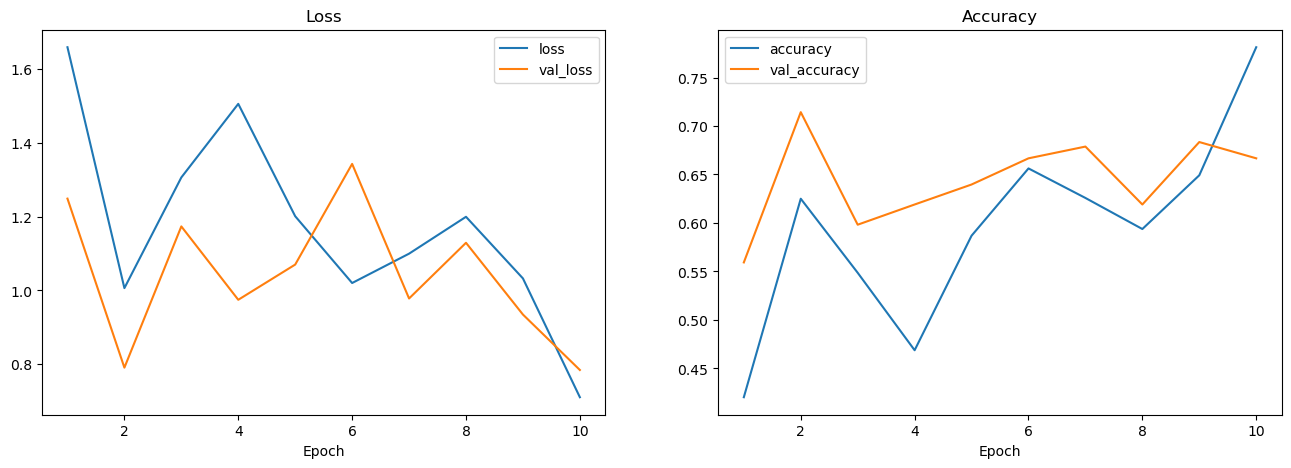

In [73]:


epoch=10

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

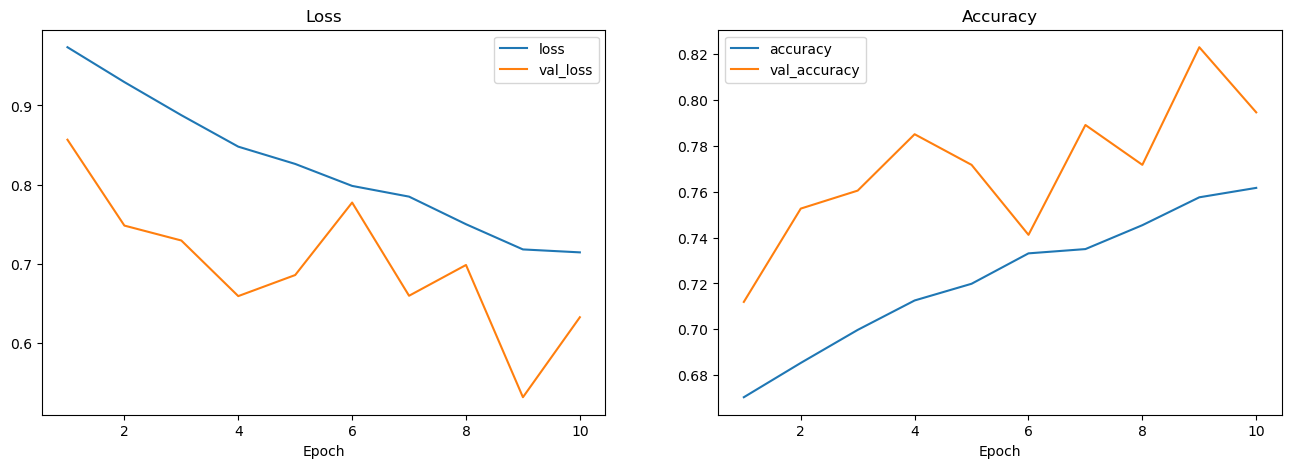

In [74]:


epoch=10

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),historyF.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),historyF.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),historyF.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),historyF.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

In [75]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model.predict(test_generator)

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

## Display Classification Report
print(classification_report(test_generator.classes, y_pred_class_aug, target_names=np.array(list(train_generator.class_indices.keys()))))

148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 215ms/step
              precision    recall  f1-score   support

     battery       0.03      0.03      0.03       189
  biological       0.03      0.03      0.03       197
   cardboard       0.11      0.15      0.13       468
     clothes       0.23      0.24      0.23      1065
       glass       0.15      0.13      0.14       819
       metal       0.10      0.10      0.10       373
       paper       0.12      0.15      0.13       545
     plastic       0.09      0.08      0.08       508
       shoes       0.07      0.05      0.06       395
       trash       0.02      0.01      0.02       166

    accuracy                           0.13      4725
   macro avg       0.09      0.10      0.09      4725
weighted avg       0.13      0.13      0.13      4725



In [76]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = modelF.predict(test_generator)

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

## Display Classification Report
print(classification_report(test_generator.classes, y_pred_class_aug, target_names=np.array(list(train_generator.class_indices.keys()))))

148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 214ms/step
              precision    recall  f1-score   support

     battery       0.01      0.01      0.01       189
  biological       0.05      0.01      0.01       197
   cardboard       0.00      0.00      0.00       468
     clothes       0.44      0.00      0.01      1065
       glass       0.17      0.85      0.29       819
       metal       0.04      0.00      0.01       373
       paper       0.15      0.02      0.03       545
     plastic       0.05      0.00      0.00       508
       shoes       0.09      0.10      0.09       395
       trash       0.05      0.02      0.03       166

    accuracy                           0.16      4725
   macro avg       0.11      0.10      0.05      4725
weighted avg       0.17      0.16      0.07      4725



Results of both models are very poor. We will be using Transfer Learning in order to improve the performance of the model. We will be moving forward with the `Sequential` as it does not tend to overfit compared to the `Functional` model.

# Transfer Learning



Transfer learning is a machine learning technique where a model developed for one task is reused as the starting point for a model on a second, related task. This approach leverages the knowledge gained from solving one problem to help solve another problem. It is particularly useful in deep learning and computer vision where training models from scratch can be computationally expensive and require large datasets.

In [77]:
# Define the model building function using transfer learning
def build_model(hp):
    base_model = VGG16(include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False  # Freeze the base model

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=32),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [78]:
# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,  # Adjust this based on your requirements
    executions_per_trial=1,
    directory='kt_dir',
    project_name='kt_hyperparameter_tuning_transfer_learning'
)


We only conduct two trials as the size of data used for training combined with lack of computational resources makes further testing time inefficient.

In [79]:
# Run the hyperparameter search
tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # Number of epochs for each trial
)

Trial 2 Complete [01h 44m 42s]
val_accuracy: 0.9047619104385376

Best val_accuracy So Far: 0.9047619104385376
Total elapsed time: 03h 40m 45s


In [80]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [81]:
# Build the best model
best_model = tuner.hypermodel.build(best_hps)

In [82]:
# Train the best model
history = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 1188s 2s/step - accuracy: 0.5461 - loss: 1.3120 - val_accuracy: 0.7496 - val_loss: 0.6857
Epoch 2/10
  1/738 ━━━━━━━━━━━━━━━━━━━━ 16:06 1s/step - accuracy: 0.6250 - loss: 1.0620

2024-05-21 02:25:43.889334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6250 - loss: 1.0620 - val_accuracy: 0.8571 - val_loss: 0.5992
Epoch 3/10


2024-05-21 02:25:44.824239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 1186s 2s/step - accuracy: 0.6897 - loss: 0.8998 - val_accuracy: 0.7878 - val_loss: 0.5859
Epoch 4/10
  1/738 ━━━━━━━━━━━━━━━━━━━━ 15:54 1s/step - accuracy: 0.8125 - loss: 0.6128

2024-05-21 02:45:31.878168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8125 - loss: 0.6128 - val_accuracy: 0.7619 - val_loss: 0.6114
Epoch 5/10


2024-05-21 02:45:32.797310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 1182s 2s/step - accuracy: 0.7102 - loss: 0.8400 - val_accuracy: 0.8027 - val_loss: 0.5570
Epoch 6/10
  1/738 ━━━━━━━━━━━━━━━━━━━━ 15:35 1s/step - accuracy: 0.5938 - loss: 0.9738

2024-05-21 03:05:16.522513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5938 - loss: 0.9738 - val_accuracy: 0.6190 - val_loss: 0.6615
Epoch 7/10


2024-05-21 03:05:17.413469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 1180s 2s/step - accuracy: 0.7164 - loss: 0.8107 - val_accuracy: 0.8129 - val_loss: 0.5324
Epoch 8/10
  1/738 ━━━━━━━━━━━━━━━━━━━━ 16:00 1s/step - accuracy: 0.7188 - loss: 0.7710

2024-05-21 03:24:58.773326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7188 - loss: 0.7710 - val_accuracy: 0.8095 - val_loss: 0.5410
Epoch 9/10


2024-05-21 03:24:59.679324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 1173s 2s/step - accuracy: 0.7304 - loss: 0.7752 - val_accuracy: 0.8227 - val_loss: 0.5065
Epoch 10/10
  1/738 ━━━━━━━━━━━━━━━━━━━━ 15:45 1s/step - accuracy: 0.7188 - loss: 0.5600

2024-05-21 03:44:34.338022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


738/738 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7188 - loss: 0.5600 - val_accuracy: 0.5714 - val_loss: 0.7905


2024-05-21 03:44:35.239592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [83]:
# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


148/148 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8126 - loss: 0.5132
Test Loss: 0.5074321627616882
Test Accuracy: 0.818835973739624


The model achieved an accuracy of approximately 81.26% on the training set and 81.88% on the test set. The loss values indicate that the model's performance is decent, with a test loss of around 0.5074. These metrics suggest that the model is learning effectively and generalizing well to unseen data.

In [84]:
# Predict the labels for validation data
validation_generator.reset()
Y_pred = best_model.predict(validation_generator, validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

148/148 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step


In [85]:

# Get the true labels
y_true = validation_generator.classes

In [87]:
# Print the summary of the search results
tuner.results_summary()

Results summary
Results in kt_dir/kt_hyperparameter_tuning_transfer_learning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
dense_units: 256
dropout_rate: 0.4
learning_rate: 0.0032966542033772053
Score: 0.9047619104385376

Trial 1 summary
Hyperparameters:
dense_units: 320
dropout_rate: 0.0
learning_rate: 0.005407624490575333
Score: 0.9047619104385376


Both trials achieved the same validation accuracy of approximately 90.48%. It's interesting to see that Trial 0 utilized dropout regularization while Trial 1 did not. Additionally, Trial 1 had a higher learning rate and more dense units. These results suggest that dropout might not significantly impact performance

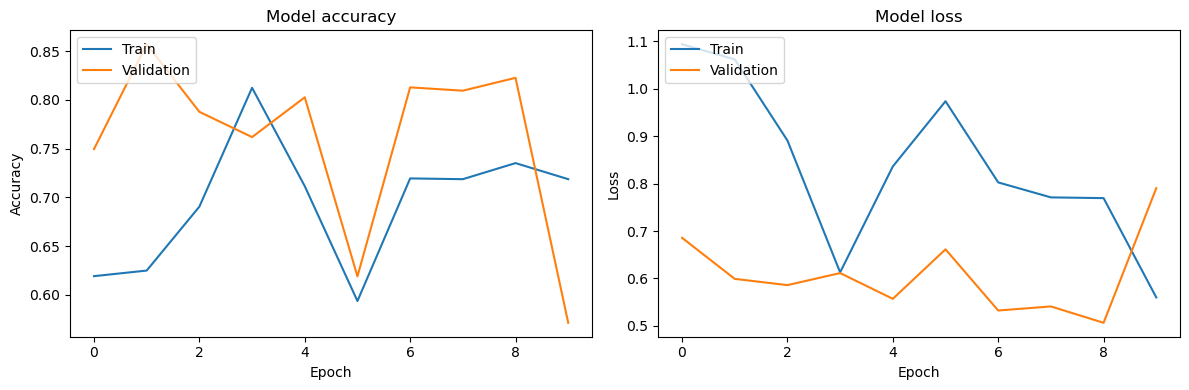

In [88]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Model Saving

In [90]:
# Save the best model
best_model.save('best_transfer_learning_model.h5')

# Model Inference

Check P2_G7_Titan_Russo_inference.ipynb

# Conclusion

With an overall accuracy of 82% after tuning, the model demonstrates a solid performance in classifying waste materials. However, there is room for refinement, particularly in classes with lower precision and recall scores. Fine-tuning the model architecture, optimizing hyperparameters, or augmenting the dataset with additional samples for underrepresented classes could potentially enhance its performance and robustness across all categories.

In conclusion, while the model showcases notable achievements in waste classification, ongoing efforts to enhance its accuracy and generalization capabilities are essential for realizing its full potential in real-world applications. test


